<a href="https://colab.research.google.com/github/VedangJotaniya/CP441_Project_Repo/blob/gh-pages/RNN_Model_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Model Creation**

In [1]:
import numpy
import cv2
from glob import glob
import argparse
from google.colab.patches import cv2_imshow

from tensorflow.keras.applications.resnet50 import ResNet50

from tensorflow.keras.layers import Flatten, Dense, Dropout, Input

from tensorflow.keras.models import Sequential, Model
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, TimeDistributed, LSTM
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense



In [2]:
IMG_HEIGHT=IMG_WIDTH=224

ResNet = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

for layer in ResNet.layers:
  layer.trainable = False


94773248/94765736 [==============================] - 1s 0us/step


In [3]:
Timesteps = 5

model = Sequential()

model.add(Input(shape = (None, IMG_HEIGHT,IMG_WIDTH,3)))
model.add(TimeDistributed(ResNet))
model.add(TimeDistributed(Flatten()))
model.add(TimeDistributed(Dense(32, activation='relu')))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(3, activation='sigmoid'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 7, 7, 2048)  23587712  
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 100352)      0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 32)          3211296   
_________________________________________________________________
lstm (LSTM)                  (None, 16)                3136      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 51        
Total params: 26,802,195
Trainable params: 3,214,483
Non-trainable params: 23,587,712
_________________________________________________________________


##**Import and prepare DATASET**


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from keras.preprocessing.sequence import pad_sequences

In [6]:
ctr2 =0

def load_data(DataPath, CATEGORIES, IMAGE_SIZE, sampling_rate):
  Data = []
  for category in CATEGORIES:
    path = os.path.join(DataPath, category)
    class_num = CATEGORIES.index(category)
    for vid in os.listdir(path):
      ctr = 0
      temp = []
      try:
        video = cv2.VideoCapture(os.path.join(path, vid))
        
        while(video.isOpened()):
          ret, frame = video.read()
          if ret:
            if ctr%sampling_rate == 0:
              frame = cv2.resize(frame, (IMAGE_SIZE, IMAGE_SIZE))
              temp.append(frame)
            ctr+=1
          else:
            break
        Data.append([temp, class_num])
        
      except Exception as e:
        print("Exception is raised")


      video.release()
        

  return Data


In [7]:
folder_path = "drive/My Drive/Colab Notebooks/Data/Words/"
CATEGORIES = ['Father','Mother','Sunday']

image_size = 224
data = []
data = load_data(folder_path, CATEGORIES, image_size, 2)



In [8]:
print(len(data[1][0]))

9


0


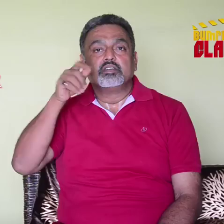

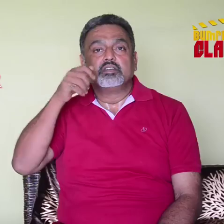

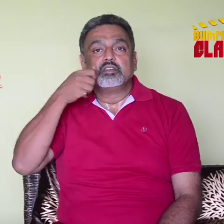

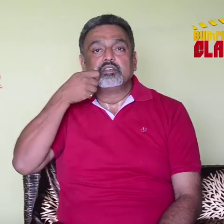

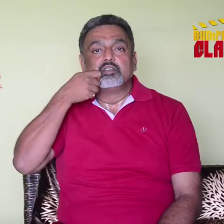

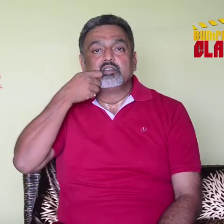

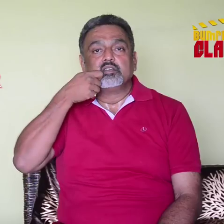

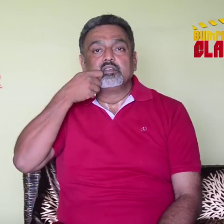

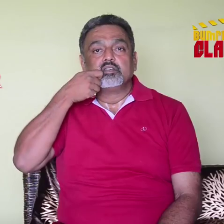

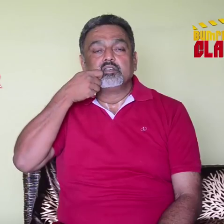

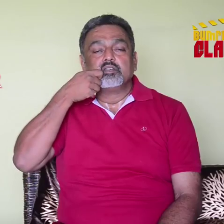

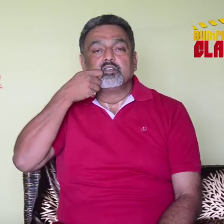

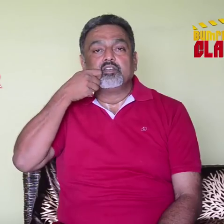

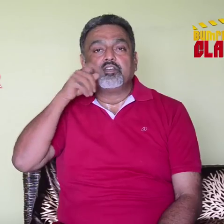

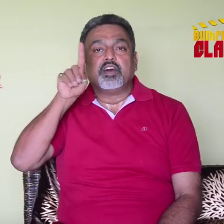

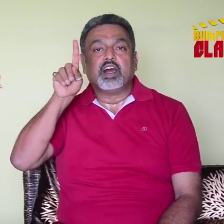

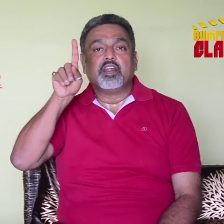

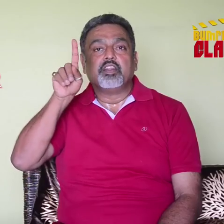

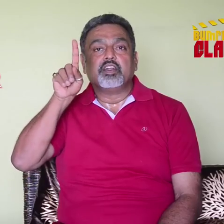

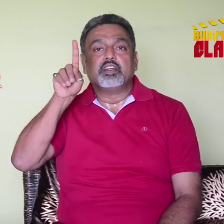

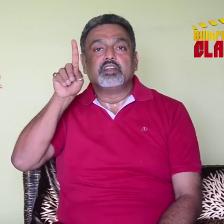

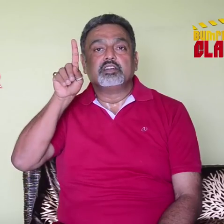

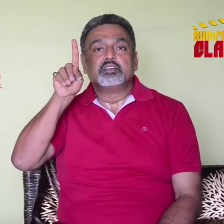

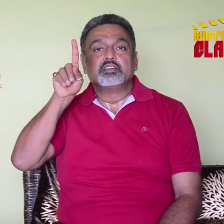

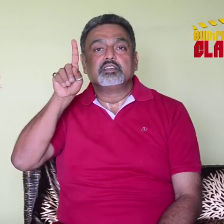

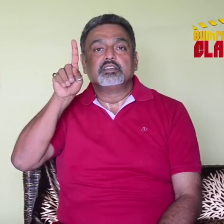

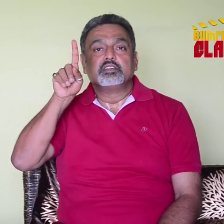

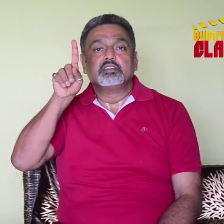

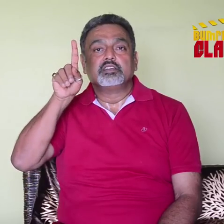

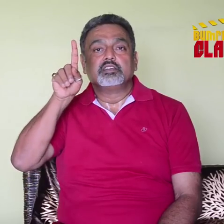

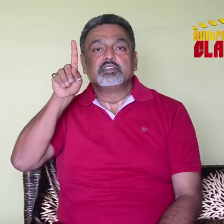

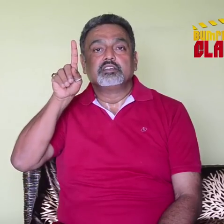

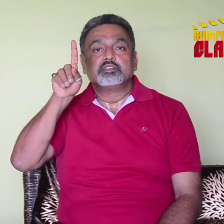

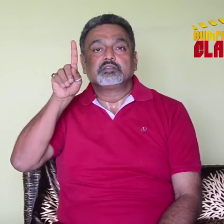

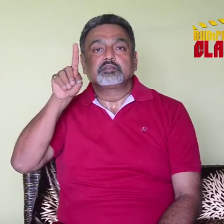

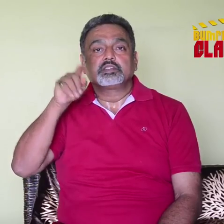

In [15]:
print(data[0][1])
for f in data[0][0]:
  cv2_imshow(f)


In [9]:
import random

random.shuffle(data)

print(len(data[0][0]))

29


### **Generating Train set and Test set**

In [10]:
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.sequence import pad_sequences

X_train = []
y_train = []

X_test = []
y_test = []

X_ = []


for d in data:
  X_.append(np.array(d[0]))
  y_train.append(d[1])

print(len(X_))
print(len(X_[0]))
padded_X = pad_sequences(X_)
print(len(padded_X[0]))

X_train = np.asarray(padded_X, dtype='float64').reshape(len(X_), -1, 224,224,3)
X_train = X_train/255

y_train = np.array(y_train)
OneHot = OneHotEncoder()
y_train = OneHot.fit_transform(y_train.reshape(-1,1)).toarray()





35
29
66


In [11]:
print(X_train.shape)

(35, 66, 224, 224, 3)


In [12]:
print(y_train.shape)

(35, 3)


### **Training the Model**

In [13]:
model.fit(X_train, y_train, epochs=1, batch_size=2 )

18/18 [==============================] - 311s 17s/step - loss: 1.1331 - accuracy: 0.2286


In [ ]:
model.predict(X_train[0])

Extra execution


In [ ]:
!pip install keras-video-generators

In [27]:
import os
import glob
import keras
from keras_video import VideoFrameGenerator
import keras_video.utils
from keras.utils import Sequence
import numpy as np

In [38]:
path = 'drive/My Drive/Colab Notebooks/Data/Words/'
classes = [i.split(os.path.sep)[-1] for i in glob.glob(path+'*')]
classes.sort()
print(classes)

img_size = (224,224)
channels = 3
frames = 20
batch_size = 1

glob_pattern = 'drive/My Drive/Colab Notebooks/Data/Words/{classname}/*'

data_aug = keras.preprocessing.image.ImageDataGenerator(
    zoom_range=.1,
    horizontal_flip=False,
    rotation_range=8,
    width_shift_range=.2,
    height_shift_range=.2)

# Create video frame generator
train = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_pattern,
    nb_frames=frames,
    split=.33, 
    shuffle=True,
    batch_size=batch_size,
    target_shape=img_size,
    nb_channel=channels,
    transformation=data_aug,
    use_frame_cache=True)

valid = train.get_validation_generator()


Warning, `split` argument is replaced by `split_val`, please condider to change your source code.The `split` argument will be removed in future releases.


['Father', 'Good morning', 'Hello', 'Monday', 'Mother', 'Sunday']
class Father, validation count: 3, train count: 9
class Good morning, validation count: 3, train count: 8
class Hello, validation count: 4, train count: 10
class Monday, validation count: 3, train count: 8
class Mother, validation count: 3, train count: 9
class Sunday, validation count: 3, train count: 8
Total data: 6 classes for 52 files for train
Total data: 6 classes for 19 files for validation


In [109]:
train2 = np.random.random(size=(10, 15, 224, 224, 3))
lst2 = []


validate2 = np.random.random(size=(10, 3))
print(train2.shape)
print(validate2.shape)
print(validate2)

(10, 15, 224, 224, 3)
(10, 3)
[[0.9323322  0.25772248 0.17223552]
 [0.30953033 0.65544014 0.40416927]
 [0.09769029 0.31401083 0.41272477]
 [0.70458157 0.94938237 0.89707867]
 [0.6043471  0.21852732 0.15857008]
 [0.38861231 0.60972333 0.58970139]
 [0.08077651 0.91932639 0.8257161 ]
 [0.84017897 0.09875658 0.40047974]
 [0.4176275  0.02033808 0.0548137 ]
 [0.36710628 0.99111156 0.44149842]]


In [112]:
model.fit(train1, valid1, verbose=1, epochs=1)

model.predict(train1)

1/1 [==============================] - 0s 1ms/step - loss: 1.8168 - accuracy: 1.0000


array([[0.29775894, 0.40773255, 0.37983382],
       [0.29775894, 0.40773255, 0.37983382],
       [0.29775894, 0.40773255, 0.37983382]], dtype=float32)

In [ ]:
data = []

files = [1,2,3,4,5,6]
temp = []
for f in files:
  image = cv2.imread(str(f)+'.jpg')
  temp.append(image)

data.append([temp, 0])
data.append([temp[:4], 1])

data1 = []
data1.append(data[0][0])
data1.append(data[1][0])

In [ ]:
train = np.array(data1, dtype='float32').reshape(2, -1,320,240,3)



ValueError: ignored

In [83]:
# keras_video.utils.show_sample(train)

img = np.zeros((224,224,3))
print(img.shape)
lst1= [[img, img, img],[img,img,img,img], [img,img]]

ctr = 0

for i in range(len(lst1)):
  if len(lst1[i]) > ctr:
    ctr=len(lst1[i])

for i in range(len(lst1)):
  if len(lst1[i])<ctr:
    padding = []
    for j in range(ctr-len(lst1[i])):
      padding.append(img) 
    for j in range(len(lst1[i])):
      padding.append(lst1[i][j])

    lst1[i] = padding

print('ctr = ', ctr)
print('len 0 = ', len(lst1[2]))

train1 = np.asarray(lst1, dtype='float64')


valid1 = [[0.41439044, 0.6188513 , 0.6342806 ],
       [0.41439044, 0.6188513 , 0.6342806 ],
       [0.41439044, 0.6188513 , 0.6342806 ]]
print(train1.shape)
valid1 = np.array(valid1, dtype='float64').reshape(3,-1)
print(valid1.shape)
print(valid1)

(224, 224, 3)
ctr =  4
len 0 =  4
(3, 4, 224, 224, 3)
(3, 3)
[[0.41439044 0.6188513  0.6342806 ]
 [0.41439044 0.6188513  0.6342806 ]
 [0.41439044 0.6188513  0.6342806 ]]


In [ ]:
print(train.shape)

(2, 6, 320, 240, 3)
